ResNet-18
=========

[https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385)

With batch_norm folded into convolutional layers for speed.

## Network info

Trained in: [fb.resnet.torch](https://github.com/facebook/fb.resnet.torch/tree/master/pretrained)
    
Test top-1/top5 error: **30.43, 10.76**

In [8]:
import re
import hickle as hkl
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from visualize import make_dot

Weights of this networks are in `hdf5` format and should be easy to load in other frameworks

In [9]:
params = hkl.load('resnet-18-export.hkl')

# convert numpy arrays to torch Variables
for k,v in params.iteritems():
    print k, v.shape
    params[k] = Variable(torch.from_numpy(v))

group3.block1.conv1.weight (512, 512, 3, 3)
group2.block0.conv0.bias (256,)
group3.block0.conv1.weight (512, 512, 3, 3)
group2.block1.conv1.weight (256, 256, 3, 3)
group1.block0.conv1.bias (128,)
group0.block0.conv0.weight (64, 64, 3, 3)
group2.block0.conv0.weight (256, 128, 3, 3)
group1.block0.conv_dim.weight (128, 64, 1, 1)
group3.block1.conv0.bias (512,)
group3.block1.conv1.bias (512,)
group0.block0.conv1.bias (64,)
group1.block0.conv0.bias (128,)
group0.block1.conv1.weight (64, 64, 3, 3)
group3.block0.conv1.bias (512,)
group2.block0.conv1.weight (256, 256, 3, 3)
group1.block0.conv0.weight (128, 64, 3, 3)
conv0.weight (64, 3, 7, 7)
group3.block0.conv_dim.weight (512, 256, 1, 1)
group0.block0.conv0.bias (64,)
fc.weight (1000, 512)
group1.block1.conv1.bias (128,)
group0.block1.conv0.weight (64, 64, 3, 3)
group1.block1.conv0.bias (128,)
conv0.bias (64,)
group1.block0.conv1.weight (128, 128, 3, 3)
group2.block1.conv1.bias (256,)
group1.block1.conv0.weight (128, 128, 3, 3)
group0.block1.

## Model definition

In [12]:
def define_model(params):
    def conv2d(input, params, base, stride=1, pad=0):
        return F.conv2d(input, params[base + '.weight'],
                        params[base + '.bias'], stride, pad)

    def group(input, params, base, stride, n):
        o = input
        for i in range(0,n):
            b_base = ('%s.block%d.conv') % (base, i)
            x = o
            o = conv2d(x, params, b_base + '0', pad=1, stride=i==0 and stride or 1)
            o = F.relu(o)
            o = conv2d(o, params, b_base + '1', pad=1)
            if i == 0 and stride != 1:
                o += F.conv2d(x, params[b_base + '_dim.weight'], stride=stride)
            else:
                o += x
            o = F.relu(o)
        return o
    
    # determine network size by parameters
    blocks = [sum([re.match('group%d.block\d+.conv0.weight'%j, k) is not None
                   for k in params.keys()]) for j in range(4)]

    def f(input, params):
        o = F.conv2d(input, params['conv0.weight'], params['conv0.bias'], 2, 3)
        o = F.relu(o)
        o = F.max_pool2d(o, 3, 2, 1)
        o_g0 = group(o, params, 'group0', 1, blocks[0])
        o_g1 = group(o_g0, params, 'group1', 2, blocks[1])
        o_g2 = group(o_g1, params, 'group2', 2, blocks[2])
        o_g3 = group(o_g2, params, 'group3', 2, blocks[3])
        o = F.avg_pool2d(o_g3, 7, 1, 0)
        o = o.view(o.size(0), -1)
        o = F.linear(o, params['fc.weight'], params['fc.bias'])
        return o
    return f

f = define_model(params)

In [13]:
y = f(Variable(torch.randn(1,3,224,224)), params)
print y

Variable containing:
-0.9344 -0.5967 -0.5097  ...   0.1952  1.8164  1.8915
[torch.FloatTensor of size 1x1000]



do simple fprop, output shape should be `1x1000`

## Visualization

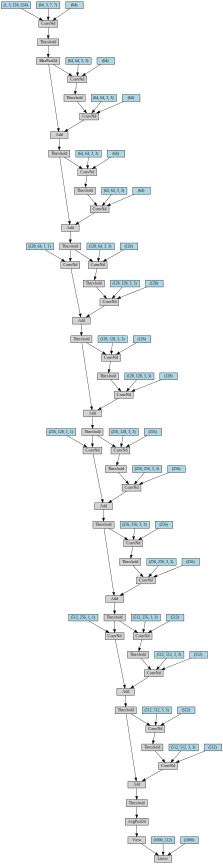

In [14]:
make_dot(y)